In [127]:
# reference: https://www.tensorflow.org/text/tutorials/transformer

# !pip install tensorflow_datasets
# !pip install -U tensorflow-text==2.7.3
import logging
import numpy as np
import matplotlib.pyplot as plt

In [128]:
def get_angles(pos, i, d_model, freq = 10000):
  angle_rates = 1 / np.power(freq, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [129]:
def positional_encoding(position, d_model, freq=10000):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model, freq=freq)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [130]:
def compareFrequency(n, d_model, freqs=[10000]):
  dists_by_freq = []
  for freq in freqs:
    pos_encoding = positional_encoding(n, d, freq)[0]
    dists = [[0] * n for i in np.arange(n)]
    for i in np.arange(n):
      for j in np.arange(n):
        if i >= j:
          dists[i][j] = np.sum(np.dot(pos_encoding[i,:], pos_encoding[j,:])) 
    for i in np.arange(n):
      for j in np.arange(n):
        if i < j:
          dists[i][j] = dists[j][i]
    dists_by_freq.append(dists[:4])
  return dists_by_freq
  

## Positional Encoding

The positional encoding in the transformer tries to encode the relationships among toekns at different positions (tokens are more affected by their closer neighors than those are farther away). The current implementation utilizes the fact that sin/cos waves which are closer in the frequency space are closer to each other in the cosine distance space of embedding features. To make the positional encoding effects controllable, we need to add the adjustable weighting when adding the positional embeddings (e.g. a single weight for positional encoding).

Using the carrier modulation to integrate positional encoding, instead of encoding addition, can avoid the tuning of relative weights between original embeddings and the positional encoded embeddings (research idea about two years ago).

**Below**, we show how the different parameters of (n, d_model) affects the correctness of positional encoding. In a nutshell, frequency precision (proportional to 1/freq) needs to be small or freq here needs to be large to avoid periodic effect of sin/cos. That means, d_model needs to be large and n needs to be comparatively small to d_model to ensure the precision of position encoding.

In [133]:
freqs = [1, 10, 100, 1000, 10000, 100000]

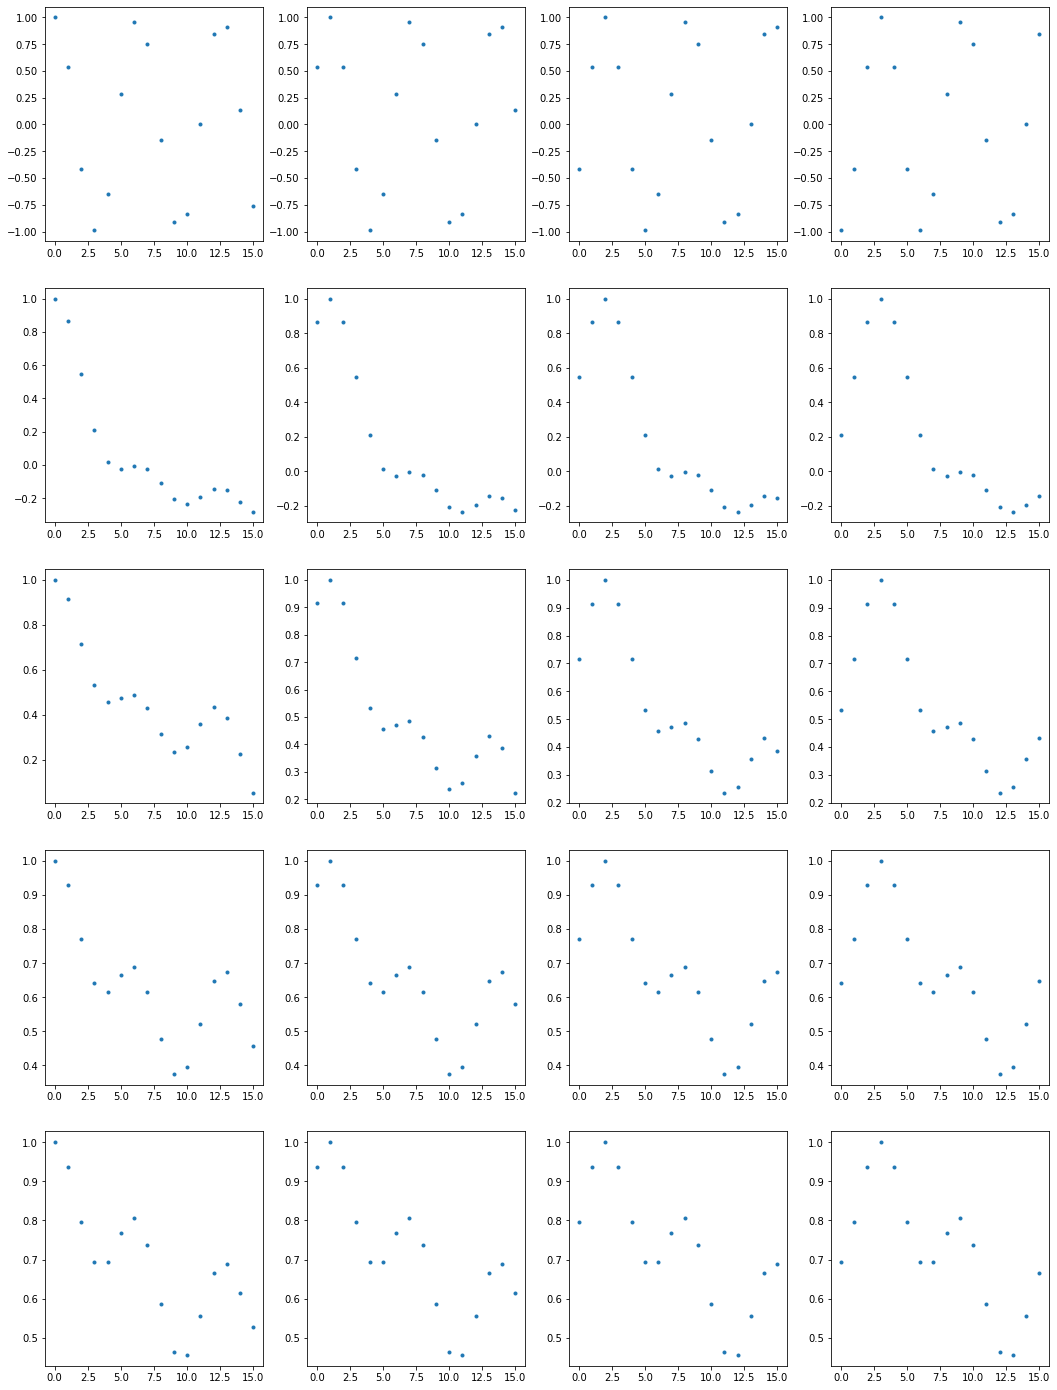

In [138]:
# if d is too small, the sequence does not approximate the sin/cos wave well, 
# which introduce inaccuracy in distance calculation between two sin/cos of different frequency.
n = 32
d = 16
dists_by_freq = compareFrequency(n, d, freqs)

n_freq = 5
n_pos = 4
valid_pos = 16
fig, axs = plt.subplots(n_freq, n_pos, figsize=[18, 25])
for i in np.arange(n_freq):
  for j in np.arange(n_pos):
    freq_precision = np.power(freqs[i], (2 * (j//2)) / np.float32(d))
    axs[i][j].plot(dists_by_freq[i][j][:valid_pos]/np.max(dists_by_freq[i]), '.',
                   label=f'freq precision: {freq_precision}')

In [ ]:
# if d is small compared to n, the assumed relational effects that closer 
# tokens affect each other more will be affected by the sin/cos periodic property, because the frequency precision/step gets too big.
# We can see that tokens farther can affect the token much more than the closer ones.

n = 2048
d = 512
dists_by_freq = compareFrequency(n, d, [1, 10, 100, 1000, 10000, 100000])

n_freq = 5
n_pos = 4
valid_pos = 16
fig, axs = plt.subplots(n_freq, n_pos, figsize=[18, 25])
for i in np.arange(n_freq):
  for j in np.arange(n_pos):
    axs[i][j].plot(dists_by_freq[i][j][:valid_pos]/np.max(dists_by_freq[i]), '.')

In [119]:
# Example of the correct parameter set.
n = 32
d = 512
dists_by_freq = compareFrequency(n, d, [1, 10, 100, 1000, 10000, 100000])

n_freq = 5
n_pos = 4
valid_pos = 16
fig, axs = plt.subplots(n_freq, n_pos, figsize=[18, 25])
for i in np.arange(n_freq):
  for j in np.arange(n_pos):
    axs[i][j].plot(dists_by_freq[i][j][:valid_pos]/np.max(dists_by_freq[i]), '.')